In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
from tqdm import tqdm
from sklearn import cluster
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import scipy
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from kneed import KneeLocator
from scipy.interpolate import interp1d
from sklearn.neighbors import NearestNeighbors

D:\python\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_excel('D:/UW/project/6ppd-experiments/tl/20210226_tlft_repeat/Leaching-dbscan-ACS.xlsx')

In [3]:
def eps_assess(data, min_pts):
    neigh = NearestNeighbors(n_neighbors=min_pts)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    x = np.arange(1, len(distances)+1)
    y = distances
    plt.plot(x, y)
    f = interp1d(x, y)
    kn = KneeLocator(x, y, curve='convex', direction='increasing')
    plt.scatter(kn.knee, f(kn.knee), color='red', marker='+', s=50)
    print('eps selected', f(kn.knee))
    return distances

In [4]:
df = df[(df.iloc[:,3:].max(1)>10000) & (df['Average Rt(min)']>2) & (df['Average Rt(min)']<18) & (df['Average Mz'] < 800) & (df['S/N average'] > 5)].copy()

In [3]:
def triplicate_mean(dataframe):
    result = list(dict.fromkeys([i[:-2] for i in dataframe.columns]))
    mean_list = []
    for i in result:
        mean_list.append(list(dataframe[dataframe.columns[dataframe.columns.str.contains(i)]].mean(1)))
    df_m = pd.DataFrame(mean_list).T
    df_m.columns = result
    return df_m

In [7]:
df.iloc[:,3:]

,15min_1,15min_2,15min_3,30min_1,30min_2,30min_3,1hr_1,1hr_2,1hr_3,90min_1,...,3hr_3,4hr_1,4hr_2,4hr_3,5hr_1,5hr_2,5hr_3,6hr_1,6hr_2,6hr_3
0,172372,170712,164744,182188,159969,150882,163169,171927,154397,212712,...,168965,233375,193148,244782,202984,186525,206978,174841,211414,181520
1,44662,36398,38763,54271,35412,22133,37523,74200,51218,39953,...,50761,62364,32380,47147,11990,23843,61862,17193,11668,17596
2,16826,15399,28059,12134,18287,16902,20657,21256,18542,19176,...,16403,20853,28256,20349,23919,20242,20736,18771,14896,20427
3,172372,170712,164744,182188,159969,150882,163169,171927,154397,175199,...,168965,170048,193148,244782,202984,186525,193211,174841,51463,181520
4,114279,23327,17245,29542,17787,11821,18405,43266,23273,43792,...,29757,65792,30954,18296,71512,78366,25269,58196,53213,31321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36888,0,15411,1254,1359,848,8,399,4883,0,825,...,7,0,0,4817,265,279,0,691,225,124
36889,0,29850,3791,654,333,0,0,2057,491,1443,...,164,0,533,2401,484,71,600,263,0,0
36890,0,0,119,1363,801,266,277,23,0,491,...,228,0,0,2889,353,12,0,0,241,0
36891,0,12261,3878,582,1040,0,0,1417,0,718,...,0,0,0,3518,10,26,431,0,758,418


In [6]:
triplicate_mean(df.iloc[:,3:])

,15min,30min,1hr,90min,2hr,3hr,4hr,5hr,6hr
0,169276.000000,164346.333333,163164.333333,178341.666667,160225.666667,165668.000000,223768.333333,198829.000000,189258.333333
1,39941.000000,37272.000000,54313.666667,57961.000000,34239.000000,41193.000000,47297.000000,32565.000000,15485.666667
2,20094.666667,15774.333333,20151.666667,21300.333333,19779.666667,20684.000000,23152.666667,21632.333333,18031.333333
3,169276.000000,164346.333333,163164.333333,165837.333333,162335.666667,163667.000000,202659.333333,194240.000000,135941.333333
4,51617.000000,19716.666667,28314.666667,93790.000000,36900.333333,41106.666667,38347.333333,58382.333333,47576.666667
...,...,...,...,...,...,...,...,...,...
36888,5555.000000,738.333333,1760.666667,275.000000,4413.000000,106.333333,1605.666667,181.333333,346.666667
36889,11213.666667,329.000000,849.333333,492.666667,8777.666667,288.000000,978.000000,385.000000,87.666667
36890,39.666667,810.000000,100.000000,249.000000,111.333333,76.000000,963.000000,121.666667,80.333333
36891,5379.666667,540.666667,472.333333,750.333333,1426.000000,270.333333,1172.666667,155.666667,392.000000


In [5]:
result = list(dict.fromkeys([i[:-2] for i in df.iloc[:,3:].columns]))
mean_list = []
for i in result:
    mean_list.append(list(df.iloc[:,3:][df.iloc[:,3:].columns[df.iloc[:,3:].columns.str.contains(i)]].mean(1)))
df_m = pd.DataFrame(mean_list).T
df_m.columns = result
df_m.head()

,15min,30min,1hr,90min,2hr,3hr,4hr,5hr,6hr
0,27856.333333,27430.666667,36225.000000,24791.666667,31691.000000,28247.000000,22554.333333,24483.666667,26555.000000
1,467155.333333,809754.333333,128714.666667,446015.000000,719927.333333,934507.666667,815440.666667,510767.666667,593013.666667
2,24090.666667,27128.666667,28715.666667,154205.666667,29386.666667,25019.000000,27515.000000,24630.666667,23384.000000
3,316149.666667,341791.666667,328770.000000,257247.000000,346883.000000,355236.666667,243388.666667,283554.666667,352278.333333
4,148400.000000,148297.666667,192452.333333,58472.000000,60896.333333,159283.000000,220965.333333,121361.333333,163404.333333


In [6]:
c_data = df_m.values
c_norm = []
for row in c_data:
    c_norm.append((row-np.mean(row))/np.std(row))
c_norm = np.asarray(c_norm)
d_norm = pd.DataFrame(c_norm)
d_norm.dropna(how='all', inplace=True)
d_norm.columns = df_m.columns

eps selected 1.4464888927827282


array([0.        , 0.        , 0.        , ..., 1.61086775, 1.62000366,
       1.64915649])

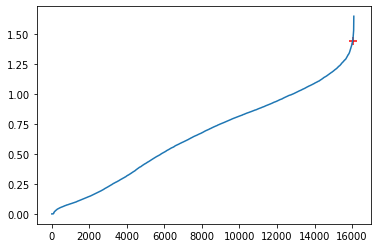

In [7]:
eps_assess(d_norm, 9)

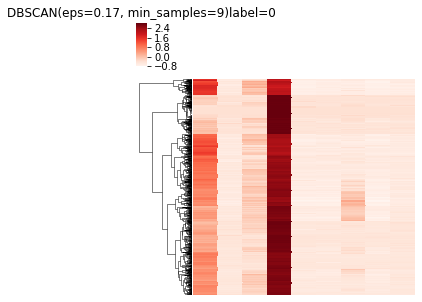

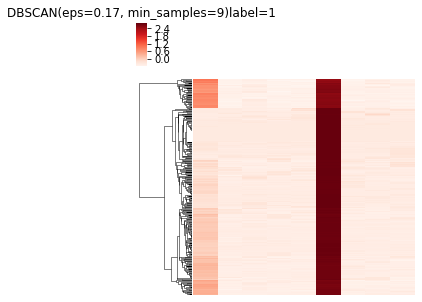

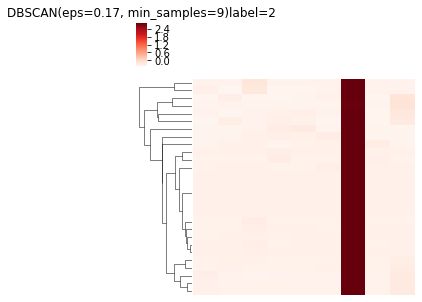

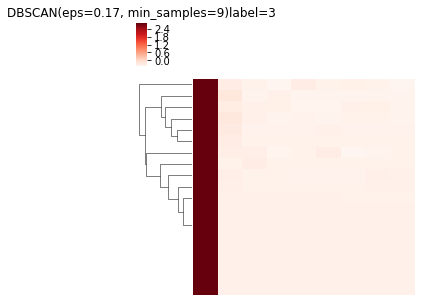

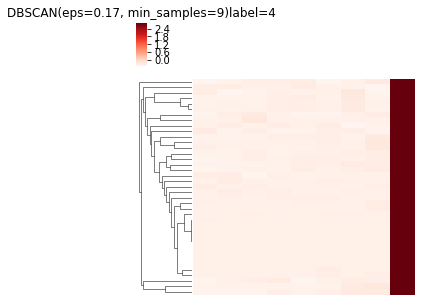

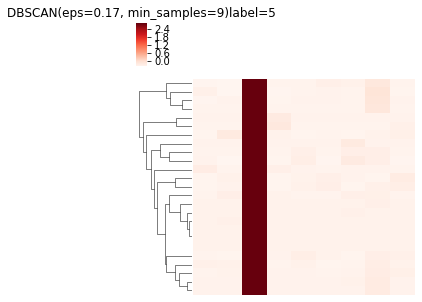

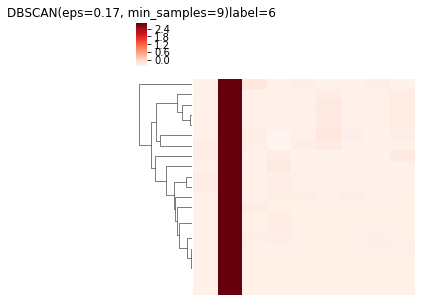

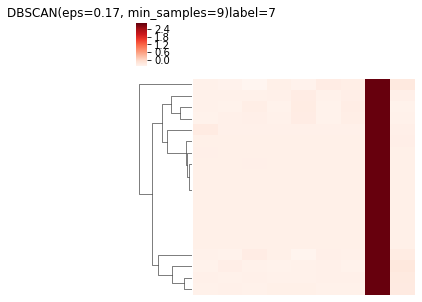

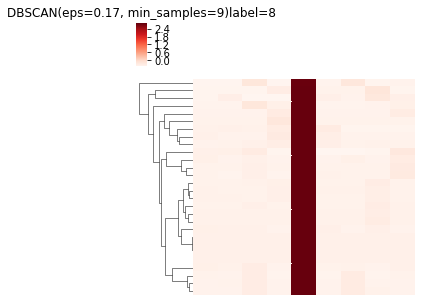

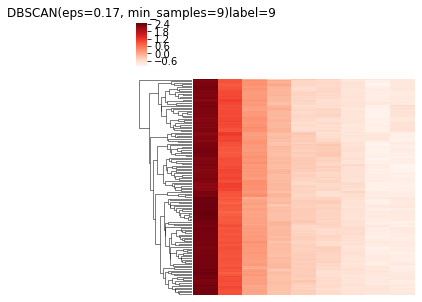

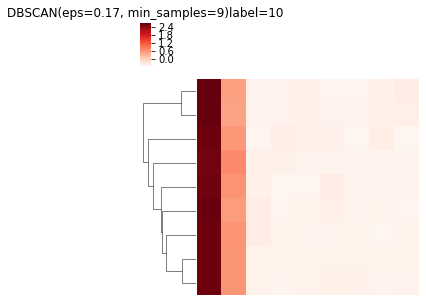

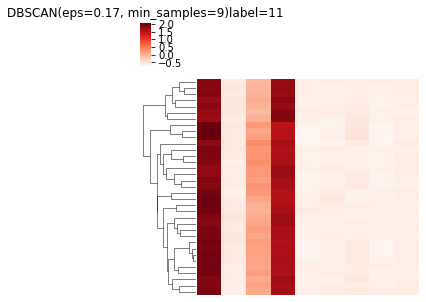

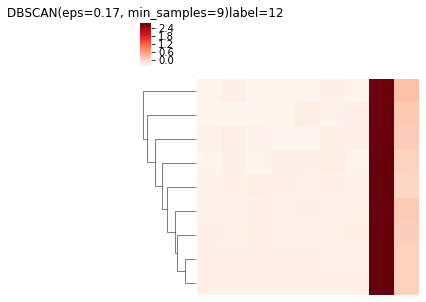

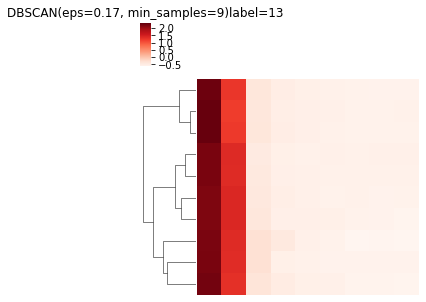

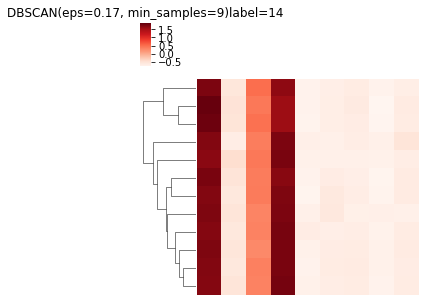

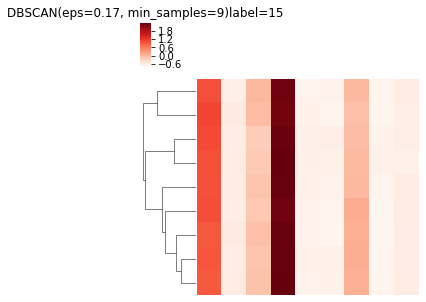

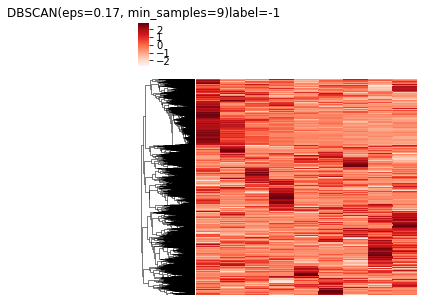

In [8]:
dbscan = cluster.DBSCAN(eps=0.17, min_samples=9).fit(d_norm)
labels = dbscan.labels_
unique_labels = list(set(dbscan.labels_))
for i, k in enumerate(unique_labels):
    indexlist = list(np.argwhere(labels == k).reshape(1, -1)[0])
    sns.clustermap(d_norm.iloc[indexlist].values, cmap='Reds',
                   col_cluster=False, yticklabels=False,
                   xticklabels=False, figsize=(5, 5))
    plt.title(str(dbscan) + 'label=' + str(k))
    plt.show()

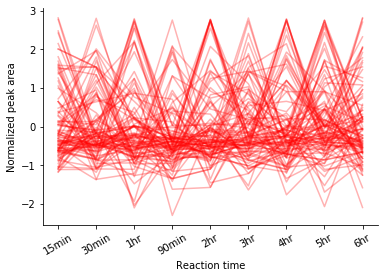

In [11]:
d_plot = d_norm
d_test = d_plot.iloc[np.argwhere(labels == -1).reshape(1,-1)[0][:100]].T
d_test.plot(legend=False,color='red',alpha=0.3)
plt.xticks(rotation=30)
plt.xlabel('Reaction time')
plt.ylabel('Normalized peak area')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)